# Lab 3: Difference-in-Differences

This lab implements difference-in-differences (DiD) estimation using two landmark studies:

- **Part 1**: Refugees and Support for the Far Right (Dinas et al., 2018)
- **Part 2**: Minimum Wages and Employment (Card & Krueger, 1994)

We cover manual DiD computation, interaction regressions, parallel trends assessment, and two-way fixed effects models.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## Part 1: Refugees and Support for the Far Right

**Dinas, E., Matakos, K., Xefteris, D. & Hangartner, D. (2019).** *Waking Up the Golden Dawn: Does Exposure to the Refugee Crisis Increase Support for Extreme-Right Parties?* Political Analysis, 27(2), 244-254.

The 2015 refugee crisis led to large-scale arrivals on Greek islands. This study uses the quasi-random assignment of refugees across municipalities to estimate the effect of refugee exposure on support for the far-right Golden Dawn party.

### Question 1: Data Exploration

In [2]:
muni = pd.read_csv('../data/lab3/did_part1.csv')

print(f'Shape: {muni.shape}')
print(f'Columns: {list(muni.columns)}')
print(f'\ntrarrprop range: {muni["trarrprop"].min():.4f} - {muni["trarrprop"].max():.4f}')
print(f'Years: {sorted(muni["year"].unique())}')
muni.head()

Shape: (384, 7)
Columns: ['municipality', 'ever_treated', 'treatment', 'year', 'gdvote', 'trarrprop', 'logdist']

trarrprop range: 0.0000 - 5.0000
Years: [np.int64(2012), np.int64(2013), np.int64(2015), np.int64(2016)]


,municipality,ever_treated,treatment,year,gdvote,trarrprop,logdist
0,7,False,0,2012,7.982288,0.0,5.480972
1,7,False,0,2013,7.277168,0.0,5.480972
2,7,False,0,2015,6.363300,0.0,5.480972
3,7,False,0,2016,7.617790,0.0,5.480972
4,3,False,0,2012,2.582918,0.0,5.763591


### Question 2: Post-Treatment-Only Regression

Using only 2016 observations, compare Golden Dawn vote share between treated and untreated municipalities. Does the coefficient represent the ATT?

In [3]:
post = muni[muni['year'] == 2016]
post_model = smf.ols('gdvote ~ treatment', data=post).fit()
print(post_model.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.6591      0.251     22.517      0.000       5.160       6.158
treatment      2.7448      0.711      3.861      0.000       1.333       4.156


**No**, this does not represent the ATT. Comparing only post-treatment outcomes ignores pre-existing differences between treated and untreated municipalities. Any systematic differences in baseline support for Golden Dawn would bias the estimate.

### Question 3: Manual Difference-in-Differences

Calculate the DiD estimator manually:

$$\hat{\tau}_{DiD} = (\bar{Y}_{T,post} - \bar{Y}_{C,post}) - (\bar{Y}_{T,pre} - \bar{Y}_{C,pre})$$

In [4]:
post_diff = (muni.loc[(muni['ever_treated'] == True) & (muni['year'] == 2016), 'gdvote'].mean() -
             muni.loc[(muni['ever_treated'] == False) & (muni['year'] == 2016), 'gdvote'].mean())

pre_diff = (muni.loc[(muni['ever_treated'] == True) & (muni['year'] == 2015), 'gdvote'].mean() -
            muni.loc[(muni['ever_treated'] == False) & (muni['year'] == 2015), 'gdvote'].mean())

did = post_diff - pre_diff

print(f'Post-treatment difference:  {post_diff:.6f}')
print(f'Pre-treatment difference:   {pre_diff:.6f}')
print(f'Difference-in-differences:  {did:.6f}')

Post-treatment difference:  2.744838
Pre-treatment difference:   0.621274
Difference-in-differences:  2.123564


### Question 4: DiD via Interaction Regression

Estimate the DiD using the interaction specification:

$$Y_{it} = \beta_0 + \beta_1 \cdot \text{Treated}_i + \beta_2 \cdot \text{Post}_t + \beta_3 \cdot (\text{Treated}_i \times \text{Post}_t) + \varepsilon_{it}$$

The coefficient $\hat{\beta}_3$ is the DiD estimator.

In [5]:
muni_1516 = muni[muni['year'] >= 2015].copy()
muni_1516['post'] = (muni_1516['year'] == 2016).astype(int)

did_model = smf.ols('gdvote ~ ever_treated * post', data=muni_1516).fit()
print(did_model.summary().tables[1])

                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     4.3854      0.241     18.162      0.000       3.909       4.862
ever_treated[T.True]          0.6213      0.683      0.910      0.364      -0.726       1.968
post                          1.2737      0.341      3.730      0.000       0.600       1.947
ever_treated[T.True]:post     2.1236      0.966      2.199      0.029       0.218       4.029


### Question 5-6: Parallel Trends Assessment

The DiD strategy relies on the **parallel trends assumption**: absent treatment, the outcome would have evolved similarly for treated and control groups. We assess this visually by plotting group means over time.

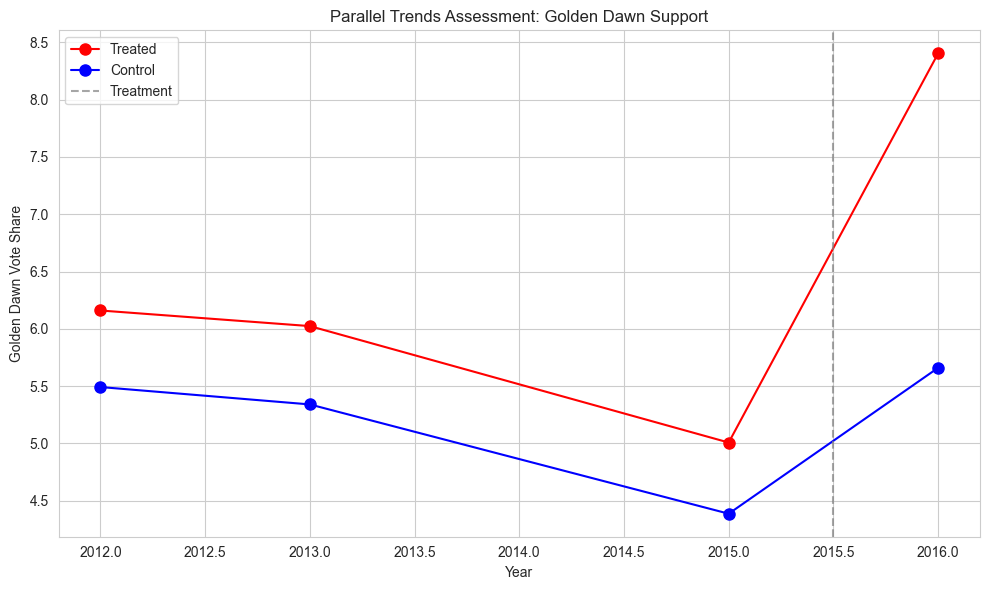

In [6]:
trends = muni.groupby(['year', 'ever_treated'])['gdvote'].mean().reset_index()

fig, ax = plt.subplots(figsize=(10, 6))
for treated, label, color in [(True, 'Treated', 'red'), (False, 'Control', 'blue')]:
    subset = trends[trends['ever_treated'] == treated]
    ax.plot(subset['year'], subset['gdvote'], 'o-', color=color, label=label, markersize=8)

ax.axvline(x=2015.5, color='gray', linestyle='--', alpha=0.7, label='Treatment')
ax.set_xlabel('Year')
ax.set_ylabel('Golden Dawn Vote Share')
ax.set_title('Parallel Trends Assessment: Golden Dawn Support')
ax.legend()
plt.tight_layout()
plt.show()

Prior to 2016, both groups follow similar trends, supporting the parallel trends assumption.

### Question 7: Two-Way Fixed Effects Regression

Estimate the DiD using municipality and year fixed effects. This controls for all time-invariant municipality characteristics and common time shocks:

$$Y_{it} = \alpha_i + \gamma_t + \delta \cdot D_{it} + \varepsilon_{it}$$

In [7]:
fe_model = smf.ols('gdvote ~ C(municipality) + C(year) + treatment', data=muni).fit()

# Extract the treatment coefficient
print(f'Treatment coefficient: {fe_model.params["treatment"]:.6f}')
print(f'SE:                    {fe_model.bse["treatment"]:.6f}')
print(f't-stat:                {fe_model.tvalues["treatment"]:.4f}')
print(f'p-value:               {fe_model.pvalues["treatment"]:.4f}')

Treatment coefficient: 2.087002
SE:                    0.393282
t-stat:                5.3066
p-value:               0.0000


### Question 8: Continuous Treatment (Refugee Arrivals Per Capita)

Replace the binary treatment with `trarrprop` (refugee arrivals per capita) to estimate the dose-response relationship.

In [8]:
fe_model_cont = smf.ols('gdvote ~ C(municipality) + C(year) + trarrprop', data=muni).fit()

print(f'trarrprop coefficient: {fe_model_cont.params["trarrprop"]:.6f}')
print(f'SE:                    {fe_model_cont.bse["trarrprop"]:.6f}')
print(f't-stat:                {fe_model_cont.tvalues["trarrprop"]:.4f}')
print(f'p-value:               {fe_model_cont.pvalues["trarrprop"]:.4f}')

trarrprop coefficient: 0.606109
SE:                    0.132437
t-stat:                4.5766
p-value:               0.0000


---

## Part 2: Minimum Wages and Employment

**Card, D. & Krueger, A.B. (1994).** *Minimum Wages and Employment: A Case Study of the Fast-Food Industry in New Jersey and Pennsylvania.* American Economic Review, 84(4), 772-793.

In April 1992, New Jersey raised its minimum wage from \\$4.25 to \\$5.05 while neighboring Pennsylvania did not. Card and Krueger surveyed fast-food restaurants in both states before and after the increase.

### Question 2: DiD for Wages

In [9]:
min_wage = pd.read_stata('../data/lab3/did_part2.dta')

print(f'Shape: {min_wage.shape}')
print(f'Columns: {list(min_wage.columns)}')
min_wage.head()

Shape: (410, 20)
Columns: ['co_owned', 'southj', 'centralj', 'pa1', 'pa2', 'wage_st', 'hrsopen', 'wage_st2', 'hrsopen2', 'emptot', 'emptot2', 'nj', 'pa', 'bk', 'kfc', 'roys', 'wendys', 'pmeal', 'pmeal2', 'closed']


,co_owned,southj,centralj,pa1,pa2,wage_st,hrsopen,wage_st2,hrsopen2,emptot,emptot2,nj,pa,bk,kfc,roys,wendys,pmeal,pmeal2,closed
0,0,0,0,1,0,NaN,16.5,4.30,16.5,40.50,24.0,0.0,1.0,1.0,0.0,0.0,0.0,2.58,NaN,0.0
1,0,0,0,1,0,NaN,13.0,4.45,13.0,13.75,11.5,0.0,1.0,0.0,1.0,0.0,0.0,4.26,4.25,0.0
2,1,0,0,1,0,NaN,10.0,5.00,11.0,8.50,10.5,0.0,1.0,0.0,1.0,0.0,0.0,4.02,4.02,0.0
3,1,0,0,1,0,5.0,12.0,5.25,12.0,34.00,20.0,0.0,1.0,0.0,0.0,0.0,1.0,3.48,2.58,0.0
4,1,0,0,1,0,5.5,12.0,4.75,12.0,24.00,35.5,0.0,1.0,0.0,0.0,0.0,1.0,3.29,2.80,0.0


In [10]:
def compute_did(df, var_pre, var_post, group_var):
    """Compute manual DiD for wide-format data."""
    pre_diff = df.loc[df[group_var] == 1, var_pre].mean(skipna=True) - df.loc[df[group_var] == 0, var_pre].mean(skipna=True)
    post_diff = df.loc[df[group_var] == 1, var_post].mean(skipna=True) - df.loc[df[group_var] == 0, var_post].mean(skipna=True)
    return pre_diff, post_diff, post_diff - pre_diff

pre, post, did = compute_did(min_wage, 'wage_st', 'wage_st2', 'nj')
print(f'=== Wages ===')
print(f'Pre-treatment difference:  {pre:.4f}')
print(f'Post-treatment difference: {post:.4f}')
print(f'DiD estimate:              {did:.4f}')

=== Wages ===
Pre-treatment difference:  -0.0180
Post-treatment difference: 0.4634
DiD estimate:              0.4814


The positive DiD for wages confirms the minimum wage increase was effective at raising wages in NJ relative to PA.

### Question 3: DiD for Employment

In [11]:
pre, post, did = compute_did(min_wage, 'emptot', 'emptot2', 'nj')
print(f'=== Employment (FTE) ===')
print(f'Pre-treatment difference:  {pre:.4f}')
print(f'Post-treatment difference: {post:.4f}')
print(f'DiD estimate:              {did:.4f}')
print(f'\nContrary to standard economic theory, the minimum wage increase')
print(f'did not reduce employment in NJ fast-food restaurants.')

=== Employment (FTE) ===
Pre-treatment difference:  -2.8918
Post-treatment difference: -0.1382
DiD estimate:              2.7536

Contrary to standard economic theory, the minimum wage increase
did not reduce employment in NJ fast-food restaurants.


### Question 4: DiD for Meal Prices

In [12]:
pre, post, did = compute_did(min_wage, 'pmeal', 'pmeal2', 'nj')
print(f'=== Meal Prices ===')
print(f'Pre-treatment difference:  {pre:.4f}')
print(f'Post-treatment difference: {post:.4f}')
print(f'DiD estimate:              {did:.4f}')

=== Meal Prices ===
Pre-treatment difference:  0.3087
Post-treatment difference: 0.3881
DiD estimate:              0.0794


### Question 5: DiD Regression in Long Format

Reshape the data from wide to long format and estimate the DiD using OLS, with and without restaurant-level covariates.

In [13]:
# Create pre-period and post-period DataFrames
pre_df = min_wage[['nj', 'wage_st', 'emptot', 'kfc', 'wendys', 'co_owned']].copy()
pre_df['treatment_period'] = 0

post_df = min_wage[['nj', 'wage_st2', 'emptot2', 'kfc', 'wendys', 'co_owned']].copy()
post_df.columns = ['nj', 'wage_st', 'emptot', 'kfc', 'wendys', 'co_owned']
post_df['treatment_period'] = 1

min_wage_long = pd.concat([pre_df, post_df], ignore_index=True)

print(f'Long format shape: {min_wage_long.shape}')

Long format shape: (820, 7)


In [14]:
# Simple DiD regression
did_simple = smf.ols('emptot ~ nj * treatment_period', data=min_wage_long).fit()
print('=== Simple DiD ===')
print(did_simple.summary().tables[1])

print()

# Covariate-adjusted DiD
did_cov = smf.ols('emptot ~ nj * treatment_period + kfc + wendys + co_owned', data=min_wage_long).fit()
print('=== Covariate-Adjusted DiD ===')
print(did_cov.summary().tables[1])

=== Simple DiD ===
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              23.3312      1.072     21.767      0.000      21.227      25.435
nj                     -2.8918      1.194     -2.423      0.016      -5.235      -0.549
treatment_period       -2.1656      1.516     -1.429      0.154      -5.141       0.810
nj:treatment_period     2.7536      1.688      1.631      0.103      -0.561       6.068

=== Covariate-Adjusted DiD ===
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              25.6099      1.024     25.008      0.000      23.600      27.620
nj                     -2.4416      1.080     -2.260      0.024      -4.562      -0.321
treatment_period       -2.2261      1.370     -1.625      0.105      